# Libraries

In [ ]:
!pip install tonic --quiet
!pip install snntorch --quiet
!pip install grad-cam -q
!pip install tensorboardX -q
!pip install pyngrok -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.6 MB/s eta 0:00:00


# Imports

In [ ]:
# imports
import tonic
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import tonic.transforms as transforms

import torch
import torchvision

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn
import time

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from tensorboardX import SummaryWriter

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device('cpu')

# Data Sample Overview

In [ ]:
dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, label = dataset[0]

# Dataset size
print("Dataset contains ", len(dataset), " samples.")

# Number of events in the first sample
print("There are ", len(events), " events in the first sample.")

# (x-pos, y-pos, polarity, timestamp)
print("A single event: ", events[0])

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST
Dataset contains  60000  samples.
There are  4542  events in the first sample.
A single event:  (15, 22, 3606, 0)


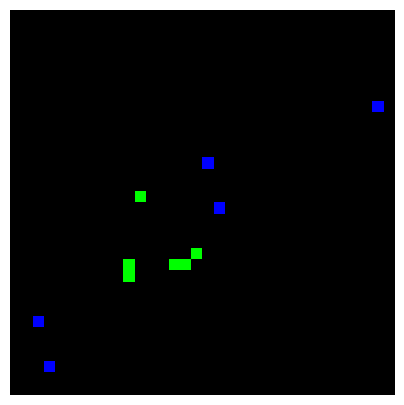

In [ ]:
single_frame_transform = transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000),
    tonic.transforms.ToFrame(
      sensor_size=tonic.datasets.NMNIST.sensor_size,
      n_time_bins=25,
    )
  ]
)

frames = single_frame_transform(events)

ani = tonic.utils.plot_animation(frames)

In [ ]:
HTML(ani.to_jshtml())

In [ ]:
mapping = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}
numbers=list(mapping.values())

# Dataloading

Shape of frames object:  torch.Size([25, 2, 34, 34])
60000
10000


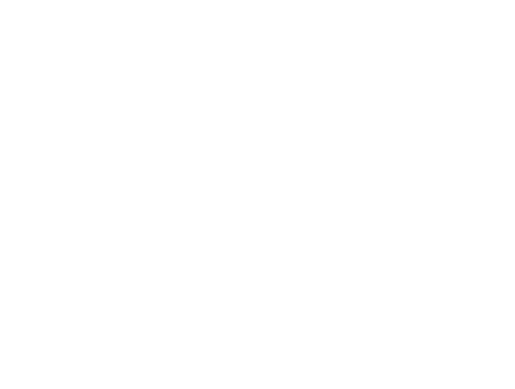

In [ ]:
size = tonic.datasets.NMNIST.sensor_size

# Denoise transform removes outlier events with inactive surrounding pixels for 10ms
denoise_transform = transforms.Denoise(filter_time=10000)

# ToFrame transform bins events into 25 clusters of frames
frame_transform = transforms.ToFrame(sensor_size=size, n_time_bins=25)

# Chain the transforms
all_transform = transforms.Compose([denoise_transform, frame_transform, torch.from_numpy, torchvision.transforms.RandomRotation([-10,10])])


train_set = tonic.datasets.NMNIST(save_to='./data', transform=all_transform, train=True)
test_set = tonic.datasets.NMNIST(save_to='./data', transform=all_transform, train=False)
print(len(train_set))
print(len(test_set))

In [ ]:
from torch.utils.data import DataLoader,Dataset

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))

# Visualize shape of sample in dataloader (similar to frames object above, but 2nd element is batch size)
for sample in iter(train_loader):
  print("Shape of sample object: ", sample[0].shape)
  break

Shape of sample object:  torch.Size([25, 128, 2, 34, 34])


# Neural Network and Training

In [ ]:
# Network parameters
gradient = surrogate.fast_sigmoid(slope=25)
beta = 0.5

# Initializing the network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(800, 10),
                    snn.Leaky(beta=beta, spike_grad=gradient, init_hidden=True, output=True)
                    ).to(device)

In [ ]:
writer = SummaryWriter("logs")

# Defining a forward propagation function
def forward_pass(net, data):
  spk_rec = []
  mem_rec = []
  snn.utils.reset(net)
  for step in range(data.size(0)):
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  writer.add_histogram('spikes', torch.stack(spk_rec), global_step=step)
  writer.add_histogram('membrane_potentials', torch.stack(mem_rec), global_step=step)
  return torch.stack(spk_rec)


# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.002, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [ ]:
num_epochs = 5
num_iters = 20

loss_hist = []
acc_hist = []
start=time.time()

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 20 iterations
        if i == num_iters:
          break
    writer.flush()
end=time.time()
print(f'Total training time{end-start} seconds.')

Epoch 0, Iteration 0 
Train Loss: 2.50
Accuracy: 8.59%

Epoch 0, Iteration 1 
Train Loss: 2.50
Accuracy: 9.38%

Epoch 0, Iteration 2 
Train Loss: 2.50
Accuracy: 7.81%

Epoch 0, Iteration 3 
Train Loss: 2.50
Accuracy: 9.38%

Epoch 0, Iteration 4 
Train Loss: 2.38
Accuracy: 8.59%

Epoch 0, Iteration 5 
Train Loss: 1.98
Accuracy: 9.38%

Epoch 0, Iteration 6 
Train Loss: 1.40
Accuracy: 12.50%

Epoch 0, Iteration 7 
Train Loss: 1.05
Accuracy: 12.50%

Epoch 0, Iteration 8 
Train Loss: 1.18
Accuracy: 10.94%

Epoch 0, Iteration 9 
Train Loss: 1.48
Accuracy: 13.28%

Epoch 0, Iteration 10 
Train Loss: 1.53
Accuracy: 11.72%

Epoch 0, Iteration 11 
Train Loss: 1.47
Accuracy: 14.06%

Epoch 0, Iteration 12 
Train Loss: 1.34
Accuracy: 14.84%

Epoch 0, Iteration 13 
Train Loss: 1.17
Accuracy: 21.09%

Epoch 0, Iteration 14 
Train Loss: 1.09
Accuracy: 20.31%

Epoch 0, Iteration 15 
Train Loss: 1.01
Accuracy: 13.28%

Epoch 0, Iteration 16 
Train Loss: 1.07
Accuracy: 14.06%

Epoch 0, Iteration 17 
Train L

In [ ]:
torch.save(net.state_dict(), 'snn_beta=.5.pth')

# Results

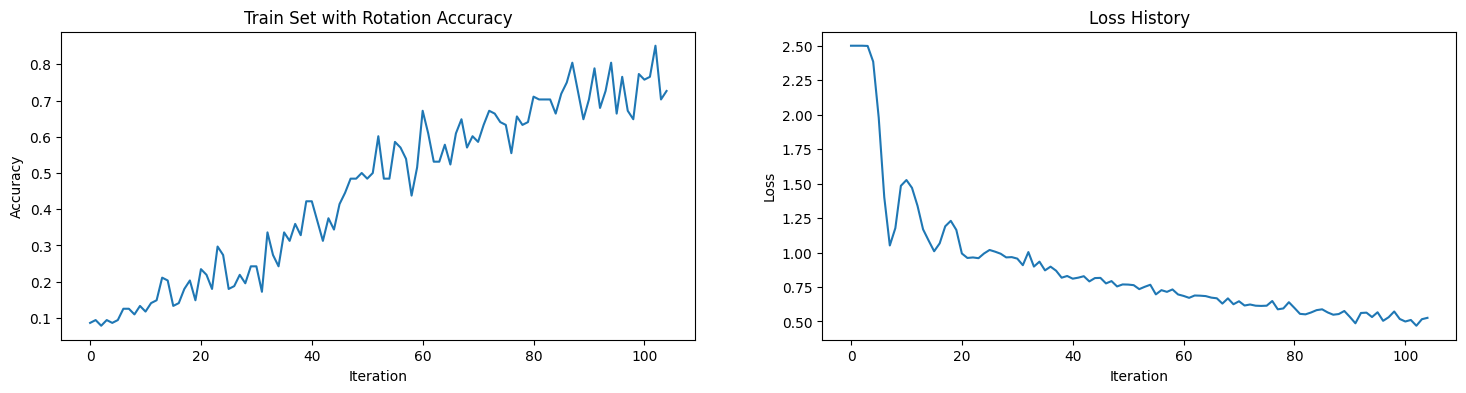

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18,4))

# Plot Train Accuracy
axes[0].plot(acc_hist)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")



# Plot Training Loss
axes[1].plot(loss_hist)
axes[1].set_title("Loss History")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")

plt.show()

In [ ]:
# Evaluate Test Set Accuracy
correct = 0
total = 0

y_test = []
predictions = []

for i, (data, targets) in enumerate(iter(test_loader)):
  data = nn.functional.interpolate(data, size=(2, 32, 32))
  data = data.to(device)
  targets = targets.to(device)
  spk_rec = forward_pass(net, data)
  correct += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
  total += spk_rec.size(1)
  _, idx = spk_rec.sum(dim=0).max(1)
  predictions.append(idx)
  y_test.append(targets)

print("Test Set Accuracy: ", (correct/total) * 100, "%")

Test Set Accuracy:  71.14 %


In [ ]:
pred_list=[]
for prediction in predictions:
    pred_list.append(prediction.tolist())

true_list=[]
for test in y_test:
    true_list.append(test.tolist())

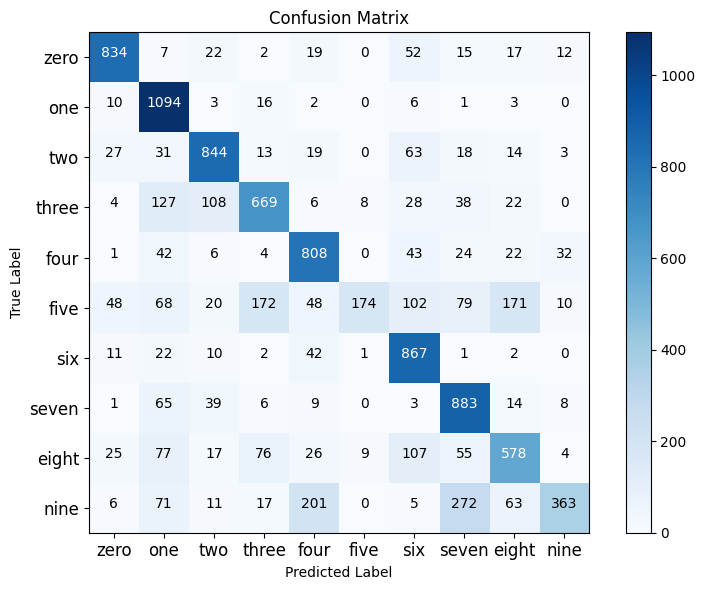

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

pred_array = np.array([label for sublist in pred_list for label in sublist])
true_array = np.array([label for sublist in true_list for label in sublist])

cm = confusion_matrix(true_array, pred_array)
plt.figure(figsize=(8, 6))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.colorbar()

classes = numbers
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt
from IPython.display import HTML

data, targets = next(iter(test_loader))


shape of data: torch.Size([25, 128, 2, 34, 34])
the target of data: tensor(6)
the shape of a sample torch.Size([25, 34, 34])


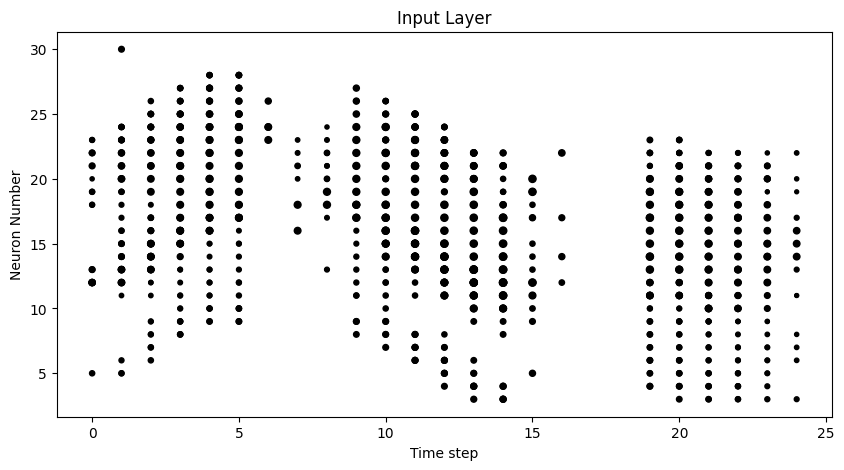

In [ ]:
#  spike_data contains 128 samples, each of 25 time steps in duration
print('shape of data:', data.shape)
print('the target of data:', targets[0])

#  Index into a single sample from a minibatch
spike_data_sample = data[:, 0, 0]
print('the shape of a sample', spike_data_sample.shape)
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample, ax,  c="black")
plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()


torch.Size([25, 128, 10])


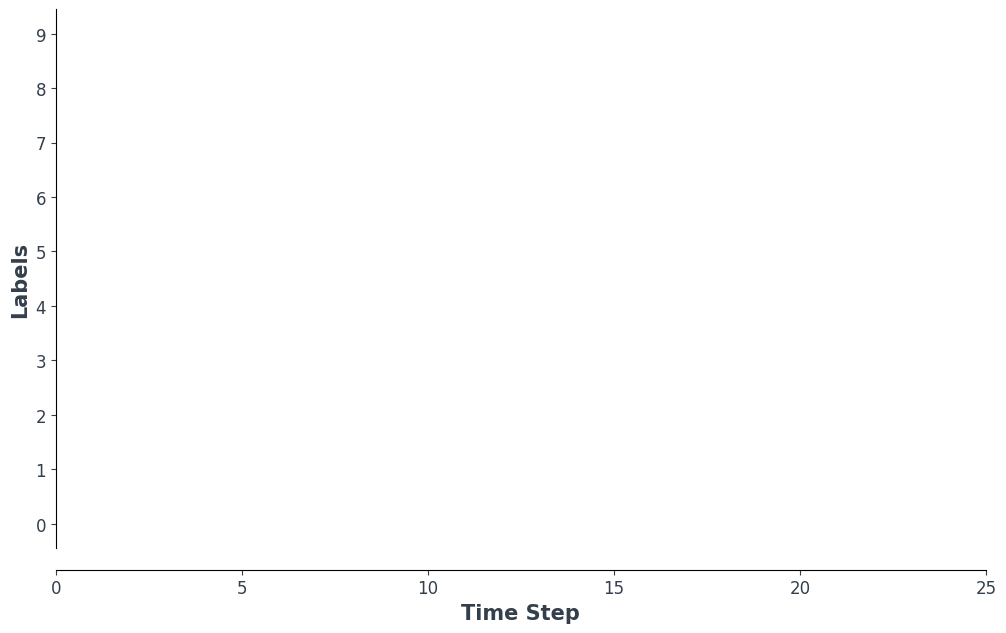

In [ ]:
spk_rec= forward_pass(net, data.to(device))

print(spk_rec.size())

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']


#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# Visualizing Weight Distribution

In [ ]:
[net[0:3]]

[Sequential(
   (0): Conv2d(2, 12, kernel_size=(5, 5), stride=(1, 1))
   (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (2): Leaky()
 )]

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

frame=data[0]
cam = GradCAM(model=net, target_layers=net[0:3])

frames=[]
for i in range(len(data)):
    frame=data[i]
    grayscale_cam = cam(input_tensor=frame, targets=None)
    heatmap=grayscale_cam[0]
    frames.append(heatmap)

for i, frame in enumerate(frames):
    plt.figure(figsize=(8, 6))
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Frame {i+1}')
    plt.show()